In [89]:
import os
import numpy as np
import pandas as pd
import math
import matplotlib.patches as patches
import matplotlib.pylab as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree
from sklearn import metrics
from sklearn import datasets
from IPython.display import Image
import seaborn as sb
%matplotlib inline

The goal is to predict the operating condition of a waterpoint for each record in the dataset. We are provided the following set of information about the waterpoints:

* amount_tsh - Total static head (amount water available to waterpoint)
* ~~date_recorded - The date the row was entered~~
* funder - Who funded the well
* gps_height - Altitude of the well
* installer - Organization that installed the well
* longitude - GPS coordinate
* latitude - GPS coordinate
* ~~wpt_name - Name of the waterpoint if there is one~~
* ~~num_private~~ wtf is this?
* basin - Geographic water basin
* subvillage - Geographic location
* region - Geographic location
* region_code - Geographic location (coded)
* district_code - Geographic location (coded)
* lga - Geographic location
* ward - Geographic location
* population - Population around the well
* public_meeting - True/False
* ~~recorded_by - Group entering this row of data~~
* scheme_management - Who operates the waterpoint
* scheme_name - Who operates the waterpoint
* permit - If the waterpoint is permitted
* construction_year - Year the waterpoint was constructed
* extraction_type - The kind of extraction the waterpoint uses
* extraction_type_group - The kind of extraction the waterpoint uses
* extraction_type_class - The kind of extraction the waterpoint uses
* management - How the waterpoint is managed
* management_group - How the waterpoint is managed
* payment - What the water costs
* payment_type - What the water costs
* water_quality - The quality of the water
* quality_group - The quality of the water
* quantity - The quantity of water
* quantity_group - The quantity of water
* source - The source of the water
* source_type - The source of the water
* source_class - The source of the water
* waterpoint_type - The kind of waterpoint
* waterpoint_type_group - The kind of waterpoint

In [93]:
# Since we are dealing with a lot of columns, let's force pandas to display all of them
pd.set_option('display.max_columns', None)

In [94]:
trainValues = pd.read_csv('train_values.csv', parse_dates = True)
trainLabels = pd.read_csv('train_labels.csv')

In [95]:
# Predefine functions
# Function to draw trees
def Decision_Tree_Image(decision_tree, feature_names, name = "temp"):
    # Export decision tree to graphviz format
    dot_file = tree.export_graphviz(decision_tree.tree_, out_file = 'images/' + name + '.dot', feature_names = feature_names)
    
    # Call graphviz to make an image file from tree
    os.system("dot -T png images/" + name + ".dot -o images/" + name + ".png")
    
    # Return the png image
    return Image(filename = "images/" + name + ".png")

# Function to draw 2D scatterplots
def Plot_Data(data, var1, var2, targetVar):
    # Make the plot square
    plt.rcParams['figure.figsize'] = [12.0, 8.0]
    
    # Pretty colors for dots
    color = ['red' if x == 'non functional' else 'blue' if x == 'functional' else 'green' for x in data[targetVar]]
    
    # Plot and label
    plt.scatter(data[var1], data[var2], c = color, s = 50)
    plt.xlabel(var1)
    plt.ylabel(var2)

In [96]:
# Merge along id
train = pd.merge(trainValues, trainLabels, on='id')

### Data Exploration

In [99]:
train.head(n = 100)

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390,Roman,34.938093,-9.856322e+00,none,0,Lake Nyasa,Mnyusi B,Iringa,11,5,Ludewa,Mundindi,109,True,GeoData Consultants Ltd,VWC,Roman,False,1999,gravity,gravity,gravity,vwc,user-group,pay annually,annually,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe,functional
1,8776,0.0,2013-03-06,Grumeti,1399,GRUMETI,34.698766,-2.147466e+00,Zahanati,0,Lake Victoria,Nyamara,Mara,20,2,Serengeti,Natta,280,NaN,GeoData Consultants Ltd,Other,NaN,True,2010,gravity,gravity,gravity,wug,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
2,34310,25.0,2013-02-25,Lottery Club,686,World vision,37.460664,-3.821329e+00,Kwa Mahundi,0,Pangani,Majengo,Manyara,21,4,Simanjiro,Ngorika,250,True,GeoData Consultants Ltd,VWC,Nyumba ya mungu pipe scheme,True,2009,gravity,gravity,gravity,vwc,user-group,pay per bucket,per bucket,soft,good,enough,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,functional
3,67743,0.0,2013-01-28,Unicef,263,UNICEF,38.486161,-1.115530e+01,Zahanati Ya Nanyumbu,0,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,63,Nanyumbu,Nanyumbu,58,True,GeoData Consultants Ltd,VWC,NaN,True,1986,submersible,submersible,submersible,vwc,user-group,never pay,never pay,soft,good,dry,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,non functional
4,19728,0.0,2011-07-13,Action In A,0,Artisan,31.130847,-1.825359e+00,Shuleni,0,Lake Victoria,Kyanyamisa,Kagera,18,1,Karagwe,Nyakasimbi,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,gravity,gravity,gravity,other,other,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,functional
5,9944,20.0,2011-03-13,Mkinga Distric Coun,0,DWE,39.172796,-4.765587e+00,Tajiri,0,Pangani,Moa/Mwereme,Tanga,4,8,Mkinga,Moa,1,True,GeoData Consultants Ltd,VWC,Zingibali,True,2009,submersible,submersible,submersible,vwc,user-group,pay per bucket,per bucket,salty,salty,enough,enough,other,other,unknown,communal standpipe multiple,communal standpipe,functional
6,19816,0.0,2012-10-01,Dwsp,0,DWSP,33.362410,-3.766365e+00,Kwa Ngomho,0,Internal,Ishinabulandi,Shinyanga,17,3,Shinyanga Rural,Samuye,0,True,GeoData Consultants Ltd,VWC,NaN,True,0,swn 80,swn 80,handpump,vwc,user-group,never pay,never pay,soft,good,enough,enough,machine dbh,borehole,groundwater,hand pump,hand pump,non functional
7,54551,0.0,2012-10-09,Rwssp,0,DWE,32.620617,-4.226198e+00,Tushirikiane,0,Lake Tanganyika,Nyawishi Center,Shinyanga,17,3,Kahama,Chambo,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,nira/tanira,nira/tanira,handpump,wug,user-group,unknown,unknown,milky,milky,enough,enough,shallow well,shallow well,groundwater,hand pump,hand pump,non functional
8,53934,0.0,2012-11-03,Wateraid,0,Water Aid,32.711100,-5.146712e+00,Kwa Ramadhan Musa,0,Lake Tanganyika,Imalauduki,Tabora,14,6,Tabora Urban,Itetemia,0,True,GeoData Consultants Ltd,VWC,NaN,True,0,india mark ii,india mark ii,handpump,vwc,user-group,never pay,never pay,salty,salty,seasonal,seasonal,machine dbh,borehole,groundwater,hand pump,hand pump,non functional
9,46144,0.0,2011-08-03,Isingiro Ho,0,Artisan,30.626991,-1.257051e+00,Kwapeto,0,Lake Victoria,Mkonomre,Kagera,18,1,Karagwe,Kaisho,0,True,GeoData Consultants Ltd,NaN,NaN,True,0,nira/tanira,nira/tanira,handpump,vwc,user-group,never pay,never pay,soft,good,enough,enough,shallo

Count missing values (Zeros count as missing for now)

In [101]:
def countNA(dataframe):
    NA = {}
    lenData = len(dataframe)
    for col in dataframe:
        zeroCount = lenData - np.count_nonzero(dataframe[col])
        nanCount = dataframe[col].isnull().sum()
        missingCount = zeroCount + nanCount
        NA['NA_{}'.format(col)] = {'count': missingCount, 'proportion': '{:.1%}'.format(float(missingCount)/float(lenData))}
    return NA
        
naCount = countNA(train)        
    

In [102]:
pd.DataFrame.from_dict(naCount, orient='index')

,count,proportion
NA_amount_tsh,41639,70.1%
NA_basin,0,0.0%
NA_construction_year,20709,34.9%
NA_date_recorded,0,0.0%
NA_district_code,23,0.0%
NA_extraction_type,0,0.0%
NA_extraction_type_class,0,0.0%
NA_extraction_type_group,0,0.0%
NA_funder,3635,6.1%
NA_gps_height,20438,34.4%


In [5]:
# Make cross table for each column against status to check for patterns
def crossTab(dataframe, refCol):
    colNames = list(dataframe.drop([refCol], 1))
    ctDict = {}
    for i in colNames:
        ctDict['crossTab_{}'.format(i)] = pd.crosstab(dataframe[i], dataframe[refCol])
    return ctDict

tables = crossTab(train, 'status_group')

In [103]:
tables['crossTab_region']

status_group,functional,functional needs repair,non functional
region,,,
Arusha,2294,175,881
Dar es Salaam,461,3,341
Dodoma,1009,209,983
Iringa,4141,123,1030
Kagera,1727,304,1285
Kigoma,1363,603,850
Kilimanjaro,2640,322,1417
Lindi,460,93,993
Manyara,987,96,500


* crossTab_quantity: most 'dry's are non-functional
* crossTab_funder: need cleaning
* crossTab_installer: need cleaning
* crossTab_subvillage: need cleaning, might be fubar
* crossTab_region, region_code, district_code: clean. more region codes than both region and district codes, not sure why
* crossTab_scheme_name: need cleaning
* crossTab_construction_year: lots of missing data

Convert to factors

In [7]:
from sklearn import preprocessing
factorConvert = [x for x in train.columns if x not in ['id','latitude','longitude','gps_height','date_recorded','construction_year','month','operation_time']]

for factor in factorConvert:
    train[factor] = preprocessing.LabelEncoder().fit_transform(train[factor])

/usr/local/lib/python2.7/site-packages/numpy/lib/arraysetops.py:216: FutureWarning: numpy not_equal will not check object identity in the future. The comparison did not return the same result as suggested by the identity (`is`)) and will change.
  flag = np.concatenate(([True], aux[1:] != aux[:-1]))


Start tree

In [62]:
excludeAttr = ['date_recorded', 'wpt_name', 'num_private', 'subvillage', 'region', 'district_code',
              'recorded_by', 'extraction_type_group', 'extraction_type_class', 'status_group', 'id']

In [63]:
Y = train['status_group']
X = train.drop(excludeAttr, axis = 1)

In [64]:
treeEntropy = DecisionTreeClassifier(max_depth = 12, criterion = 'entropy')
treeEntropy.fit(X, Y)
Decision_Tree_Image(treeEntropy, X.columns)
print "Accuracy score for tree is %.3f" %metrics.accuracy_score(treeEntropy.predict(X), Y)

Accuracy score for tree is 0.790


Initiate cross validation

In [65]:
from sklearn import cross_validation
from sklearn.cross_validation import train_test_split
Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, train_size = 0.80)

In [66]:
treeEntropy.fit(Xtrain, Ytrain)
print 'Accuracy score of tree on train = %.3f' %metrics.accuracy_score(treeEntropy.predict(Xtrain), Ytrain)
print 'Accuracy score of tree on test = %.3f' %metrics.accuracy_score(treeEntropy.predict(Xtest), Ytest) 

Accuracy score of tree on train = 0.794
Accuracy score of tree on test = 0.749


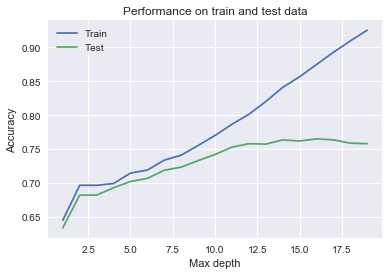

In [67]:
accuraciesTrain = []
accuraciesTest = []
depths = range(1, 20)

for md in depths:
    model = DecisionTreeClassifier(max_depth = md)
    model.fit(Xtrain, Ytrain)
    
    accuraciesTrain.append(metrics.accuracy_score(model.predict(Xtrain), Ytrain))
    accuraciesTest.append(metrics.accuracy_score(model.predict(Xtest), Ytest))

plt.plot(depths, accuraciesTrain, label = "Train")
plt.plot(depths, accuraciesTest, label = "Test")
plt.title("Performance on train and test data")
plt.xlabel("Max depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

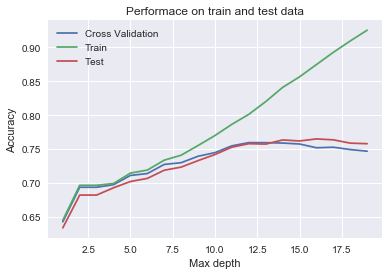

In [68]:
accuraciesCrossValidation = []
depths = range(1, 20)

for md in depths:
    model = DecisionTreeClassifier(max_depth = md)
    
    accuraciesCrossValidation.append(np.mean(cross_validation.cross_val_score(model, X, Y)))

plt.plot(depths, accuraciesCrossValidation, label = "Cross Validation")
plt.plot(depths, accuraciesTrain, label = "Train")
plt.plot(depths, accuraciesTest, label = "Test")
plt.title("Performace on train and test data")
plt.xlabel("Max depth")
plt.ylabel("Accuracy")
#plt.ylim([0.8, 1.0])
#plt.xlim([1,20])
plt.legend()
plt.show()

Quite shit. Try with random forest

Tuning the model with 100 trees, 20 min samples each leaf, no restriction on number of processors used (n_jobs).

In [71]:
from sklearn.ensemble import RandomForestClassifier
randomForest = RandomForestClassifier(max_features = 'auto', n_estimators = 100, min_samples_leaf = 20,
                                     max_depth = 20, n_jobs = -1, criterion = 'entropy')
randomForest.fit(Xtrain, Ytrain)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
            max_depth=20, max_features='auto', max_leaf_nodes=None,
            min_impurity_split=1e-07, min_samples_leaf=20,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=100, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False)

Things learned from fucking with the model
* no max_depth is better
* 100 trees seem optimum. More or less would result in worse performance

In [72]:
print 'Accuracy score of random forest on train = %.3f' %metrics.accuracy_score(randomForest.predict(Xtrain), Ytrain)
print 'Accuracy score of random forest on test = %.3f' %metrics.accuracy_score(randomForest.predict(Xtest), Ytest)

Accuracy score of random forest on train = 0.808
Accuracy score of random forest on test = 0.784


Create cross table of actual and predicted

In [15]:
forestPreds = randomForest.predict(Xtest)
pd.crosstab(Ytest, forestPreds, rownames=['Actual status'], colnames=['Predicted status'])

Predicted status,0,1,2
Actual status,,,
0,5827,176,516
1,466,269,124
2,1077,89,3336


Pretty shit to predict non-functional pumps it seems. False positive is not good.

In [73]:
list(zip(Xtrain, randomForest.feature_importances_))

[('amount_tsh', 0.025811378433106123),
 ('funder', 0.030934645522659735),
 ('gps_height', 0.032364155587371012),
 ('installer', 0.025875353574778114),
 ('longitude', 0.069154625285763188),
 ('latitude', 0.060561695856921831),
 ('basin', 0.018574781143512208),
 ('region_code', 0.027185952234292279),
 ('lga', 0.041212085428101099),
 ('ward', 0.024906569507566832),
 ('population', 0.020164721053435575),
 ('public_meeting', 0.017097026507897021),
 ('scheme_management', 0.01483542234617196),
 ('scheme_name', 0.022410375469041857),
 ('permit', 0.019239773519637432),
 ('construction_year', 0.044117465284060249),
 ('extraction_type', 0.039044304038538945),
 ('management', 0.015088546977570044),
 ('management_group', 0.0056819501603618486),
 ('payment', 0.020993178260463954),
 ('payment_type', 0.020753249709603475),
 ('water_quality', 0.0050093446945497413),
 ('quality_group', 0.004716030494633444),
 ('quantity', 0.11997187274332248),
 ('quantity_group', 0.10582913761625208),
 ('source', 0.0241

Initiate bagging

In [80]:
from sklearn.ensemble import BaggingClassifier
bagTree = BaggingClassifier(n_estimators = 50, n_jobs = -1)
bagTree.fit(Xtrain, Ytrain)

BaggingClassifier(base_estimator=None, bootstrap=True,
         bootstrap_features=False, max_features=1.0, max_samples=1.0,
         n_estimators=50, n_jobs=-1, oob_score=False, random_state=None,
         verbose=0, warm_start=False)

In [81]:
print 'Accuracy score of bagged tree on train = %.3f' %metrics.accuracy_score(bagTree.predict(Xtrain), Ytrain)
print 'Accuracy score of bagged tree on test = %.3f' %metrics.accuracy_score(bagTree.predict(Xtest), Ytest)

Accuracy score of bagged tree on train = 0.999
Accuracy score of bagged tree on test = 0.792
